In [58]:
# Import thư viện
import pandas as pd
import numpy as np

from mlxtend.frequent_patterns import apriori, association_rules

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt


In [59]:
#Đọc dữ liệu và kiểm tra cột
df = pd.read_csv("Downloads/HeartDiseaseTrain-Test.csv")

print(df.head())
print(df.columns)
print(df.info())


   age     sex chest_pain_type  resting_blood_pressure  cholestoral  \
0   52    Male  Typical angina                     125          212   
1   53    Male  Typical angina                     140          203   
2   70    Male  Typical angina                     145          174   
3   61    Male  Typical angina                     148          203   
4   62  Female  Typical angina                     138          294   

      fasting_blood_sugar               rest_ecg  Max_heart_rate  \
0    Lower than 120 mg/ml  ST-T wave abnormality             168   
1  Greater than 120 mg/ml                 Normal             155   
2    Lower than 120 mg/ml  ST-T wave abnormality             125   
3    Lower than 120 mg/ml  ST-T wave abnormality             161   
4  Greater than 120 mg/ml  ST-T wave abnormality             106   

  exercise_induced_angina  oldpeak        slope vessels_colored_by_flourosopy  \
0                      No      1.0  Downsloping                           Two   
1 

In [60]:
# Tiền xử lý dữ liệu
# Xóa dòng trùng
df = df.drop_duplicates()

# Xóa missing value
df = df.dropna()

# Chỉ lấy các cột dạng số
numeric_cols = df.select_dtypes(include=[np.number]).columns

df_numeric = df[numeric_cols].copy()

print(df_numeric.head())


   age  resting_blood_pressure  cholestoral  Max_heart_rate  oldpeak  target
0   52                     125          212             168      1.0       0
1   53                     140          203             155      3.1       0
2   70                     145          174             125      2.6       0
3   61                     148          203             161      0.0       0
4   62                     138          294             106      1.9       0


In [61]:
#Rời rạc hóa dữ liệu
apriori_df = df_numeric.copy()

for col in apriori_df.columns:
    unique_vals = apriori_df[col].nunique()
    
    if unique_vals >= 3:
        apriori_df[col] = pd.qcut(
            apriori_df[col],
            q=3,
            duplicates="drop"
        ).astype(str)
    else:
        apriori_df[col] = apriori_df[col].astype(str)

print(apriori_df.head())


            age resting_blood_pressure       cholestoral   Max_heart_rate  \
0  (51.0, 59.0]       (122.333, 138.0]  (125.999, 222.0]   (162.0, 202.0]   
1  (51.0, 59.0]         (138.0, 200.0]  (125.999, 222.0]   (143.0, 162.0]   
2  (59.0, 77.0]         (138.0, 200.0]  (125.999, 222.0]  (70.999, 143.0]   
3  (59.0, 77.0]         (138.0, 200.0]  (125.999, 222.0]   (143.0, 162.0]   
4  (59.0, 77.0]       (122.333, 138.0]    (263.0, 564.0]  (70.999, 143.0]   

         oldpeak target  
0     (0.1, 1.4]      0  
1     (1.4, 6.2]      0  
2     (1.4, 6.2]      0  
3  (-0.001, 0.1]      0  
4     (1.4, 6.2]      0  


In [62]:
#One-hot encoding cho Apriori
onehot_df = pd.get_dummies(apriori_df)

print(onehot_df.head())
print(onehot_df.shape)


   age_(28.999, 51.0]  age_(51.0, 59.0]  age_(59.0, 77.0]  \
0               False              True             False   
1               False              True             False   
2               False             False              True   
3               False             False              True   
4               False             False              True   

   resting_blood_pressure_(122.333, 138.0]  \
0                                     True   
1                                    False   
2                                    False   
3                                    False   
4                                     True   

   resting_blood_pressure_(138.0, 200.0]  \
0                                  False   
1                                   True   
2                                   True   
3                                   True   
4                                  False   

   resting_blood_pressure_(93.999, 122.333]  cholestoral_(125.999, 222.0]  \
0             

In [63]:
#Apriori – tìm tập phổ biến
frequent_itemsets = apriori(
    onehot_df,
    min_support=0.2,
    use_colnames=True
)

print(frequent_itemsets.head())


    support                                   itemsets
0  0.350993                       (age_(28.999, 51.0])
1  0.350993                         (age_(51.0, 59.0])
2  0.298013                         (age_(59.0, 77.0])
3  0.344371  (resting_blood_pressure_(122.333, 138.0])
4  0.321192    (resting_blood_pressure_(138.0, 200.0])


In [64]:
#Sinh luật kết hợp
rules = association_rules(
    frequent_itemsets,
    metric="confidence",
    min_threshold=0.6
)

rules = rules.sort_values(by="lift", ascending=False)

print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head())


                        antecedents consequents   support  confidence  \
6              (oldpeak_(1.4, 6.2])  (target_0)  0.215232    0.722222   
4  (Max_heart_rate_(70.999, 143.0])  (target_0)  0.248344    0.700935   
3   (Max_heart_rate_(162.0, 202.0])  (target_1)  0.241722    0.784946   
5           (oldpeak_(-0.001, 0.1])  (target_1)  0.254967    0.733333   
0              (age_(28.999, 51.0])  (target_1)  0.245033    0.698113   

       lift  
6  1.580515  
4  1.533929  
3  1.445450  
5  1.350407  
0  1.285550  


In [65]:
#Chuẩn hóa dữ liệu để phân cụm
scaler = StandardScaler()
X_scaled = scaler.fit_transform(onehot_df)


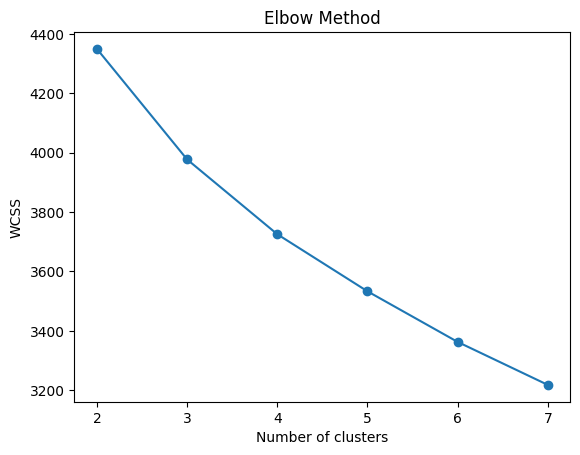

In [66]:
#Elbow Method (chạy sẽ hiện biểu đồ)
wcss = []

for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(2, 8), wcss, marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.title("Elbow Method")
plt.show()


In [67]:
#Phân cụm K-Means
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

df['Cluster'] = clusters
df['Cluster'].value_counts()


Cluster
0    134
2     89
1     79
Name: count, dtype: int64

In [68]:
#Đánh giá phân cụm
sil_score = silhouette_score(X_scaled, clusters)
print("Silhouette Score:", sil_score)


Silhouette Score: 0.13284705411153097


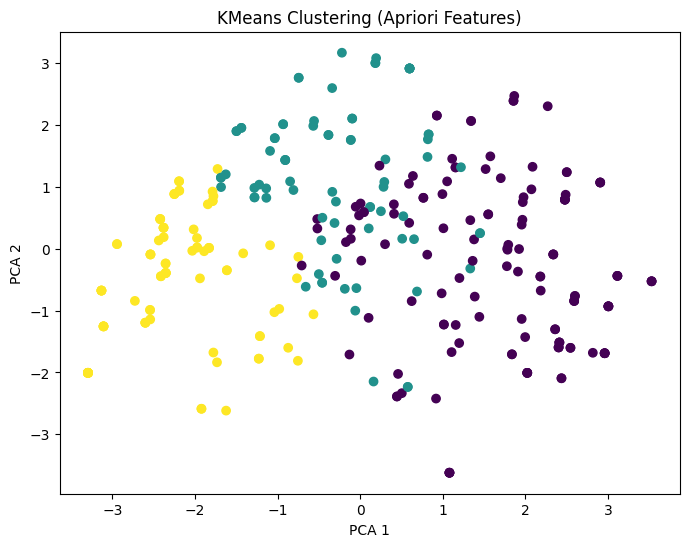

In [69]:
#Trực quan hóa PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("KMeans Clustering (Apriori Features)")
plt.show()


In [70]:
# Xuất kết quả
df.to_csv("heart_disease_clustered.csv", index=False)
rules.to_csv("association_rules.csv", index=False)
